In [2]:
import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'collocation'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation_improved import collocation_ode_solver

In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

from functools import partial

jax.config.update("jax_enable_x64", True)

In [4]:
def harmonic_oscillator(state, t, omega_squared):
    x1, x2 = state
    dx1dt = x2
    dx2dt = -omega_squared * x1
    return jnp.array([dx1dt, dx2dt])

def harmonic_oscillator_system(dphi_dt, phi, params):
    """"
    Constructs the collocation matrix for a damped oscillator system.
    
    Args:
    - dphi_dt: Matrix of derivatives of the polynomial basis functions at the collocation points.
    - phi: Matrix of the polynomial basis functions at the collocation points.
    - params: Dictionary containing the parameters 'omega_0' (natural frequency).

    Returns:
    - A: The augmented system matrix for the collocation points.
    """
    omega_squared = params.get('omega_squared', 1.0)
    return jnp.block([
        [dphi_dt, -phi],
        [omega_squared * phi, dphi_dt]
    ])

### Network Definition and Initialize

In [5]:
class ParameterEstimator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)  # Output \(\omega^2\)
        return x
    
def create_train_state(rng, learning_rate):
    model = ParameterEstimator()
    params = model.init(rng, jnp.ones((2,)))['params'] 
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

### Harmonic Oscillator System Definition 

### Generate Data

In [6]:
n_points = 100
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])
omega_squared_true = 0.25
y = odeint(harmonic_oscillator, y0, t, omega_squared_true)

rng = random.PRNGKey(0)
learning_rate = 1e-3

In [7]:
def loss_fn_coll(params, apply_fn, t, observed_data, y0, N):
    omega_squared = apply_fn({'params': params}, y0)[0]  # Predict omega^2 using initial state y0
    ode_param = {'omega_squared': omega_squared}
    pred_solution = collocation_ode_solver(harmonic_oscillator_system, y0, t, N,'Chebyshev_local', ode_param)
    
    return jnp.mean((pred_solution - observed_data) ** 2)

def train_step_coll(state, t, observed_data, y0, N):
    grad_fn = jax.value_and_grad(loss_fn_coll)  
    loss, grads = grad_fn(state.params, state.apply_fn, t, observed_data, y0, N)
    state = state.apply_gradients(grads=grads)
    return state, loss


def train_coll(state, t, observed_data, y0, N, num_epochs=1000, verbose=True):
    for epoch in range(num_epochs):
        state, loss = train_step_coll(state, t, observed_data, y0, N)
        if epoch % 25 == 0 and verbose:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

# Initialize
N = 30
state = create_train_state(rng, learning_rate)
trained_state = train_coll(state, t, y, y0, N, num_epochs = 500)

# Predict omega_squared using the trained model
omega_pred = trained_state.apply_fn({'params': trained_state.params}, y0)[0]

Epoch 0, Loss: 0.20190081125079537
Epoch 25, Loss: 0.00039896863625202733
Epoch 50, Loss: 6.269038222252373e-05
Epoch 75, Loss: 3.0182839034603227e-06
Epoch 100, Loss: 2.2769833097900843e-06
Epoch 125, Loss: 7.550164671914776e-09
Epoch 150, Loss: 1.7325726677864355e-08
Epoch 175, Loss: 4.304720334815653e-10
Epoch 200, Loss: 1.7777854484285493e-10
Epoch 225, Loss: 8.591910797688108e-13
Epoch 250, Loss: 6.596557895436268e-13
Epoch 275, Loss: 6.818261339396301e-14
Epoch 300, Loss: 3.4016714941980705e-15
Epoch 325, Loss: 1.923634434002275e-16
Epoch 350, Loss: 1.9512879838732435e-16
Epoch 375, Loss: 1.8078975772138303e-16
Epoch 400, Loss: 1.8087534668082785e-16
Epoch 425, Loss: 1.8078971071769688e-16
Epoch 450, Loss: 1.8079365793619628e-16
Epoch 475, Loss: 1.8077976594007452e-16


In [8]:
# Solve the ODE using the predicted parameter
def estimated_harmonic_oscillator(state, t, omega_squared):
    return harmonic_oscillator(state, t, omega_squared)

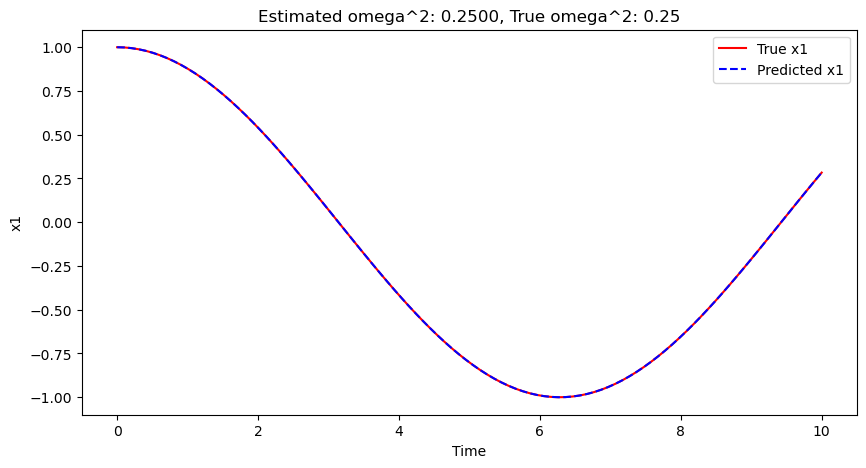

In [9]:
y_pred = odeint(estimated_harmonic_oscillator, y0, t, omega_pred)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], 'r-', label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Estimated omega^2: {omega_pred:.4f}, True omega^2: {omega_squared_true}')
plt.show()


## How can this be optimized?

### Omega = 1.0

In [10]:
class ParameterEstimator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)  # Output \(\omega^2\)
        return x
    
def create_train_state(rng, learning_rate):
    model = ParameterEstimator()
    init_input = jnp.ones((2,)) # based on the input size 
    
    params = model.init(rng, init_input)['params']
    # print(f'Initial parameters: {params}')  # Debug: Print initial parameters
    
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def loss_fn_coll(params, apply_fn, t, observed_data, y0, N):
    omega_squared = apply_fn({'params': params}, y0)[0]  # Predict omega^2 using initial state y0
    ode_param = {'omega_squared': omega_squared}
    pred_solution = collocation_ode_solver(harmonic_oscillator_system, y0, t, N, "Chebyshev_local", ode_param)
    return jnp.mean((pred_solution - observed_data) ** 2)

partial(jax.jit, static_argnames=['N'])
def train_step_coll(state, t, observed_data, y0, N):
    grad_fn = jax.value_and_grad(loss_fn_coll)
    loss, grads = grad_fn(state.params, state.apply_fn, t, observed_data, y0, N)
    # print("Grads", grads)
    state = state.apply_gradients(grads=grads)
    return state, loss

def train_coll(state, t, observed_data, y0, N, num_epochs=1000, verbose=True):
    for epoch in range(num_epochs):
        state, loss = train_step_coll(state, t, observed_data, y0, N)
        if epoch % 50 == 0 and verbose:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

n_points = 100
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])

# a more complex function to estimate
omega_squared_true = 1
y = odeint(harmonic_oscillator, y0, t, omega_squared_true)

rng = random.PRNGKey(0)
learning_rate = 1e-3

# initialize
N = 30
state = create_train_state(rng, learning_rate)

trained_state = train_coll(state, t, y, y0, N, num_epochs = 500)

Epoch 0, Loss: 0.9693310831750646
Epoch 50, Loss: 0.00036728933153823336
Epoch 100, Loss: 1.4936968468970539e-05
Epoch 150, Loss: 1.4162662315122006e-09
Epoch 200, Loss: 4.782614422735778e-10
Epoch 250, Loss: 6.752277815865216e-15
Epoch 300, Loss: 6.260553453934236e-16
Epoch 350, Loss: 5.564729874156592e-16
Epoch 400, Loss: 5.501344977449847e-16
Epoch 450, Loss: 5.492043832014237e-16


In [11]:
# Predict omega_squared using the trained model
omega_pred = trained_state.apply_fn({'params': trained_state.params}, y0)[0]

In [12]:
# Solve the ODE using the predicted parameter
def estimated_harmonic_oscillator(state, t, omega_squared):
    return harmonic_oscillator(state, t, omega_squared)

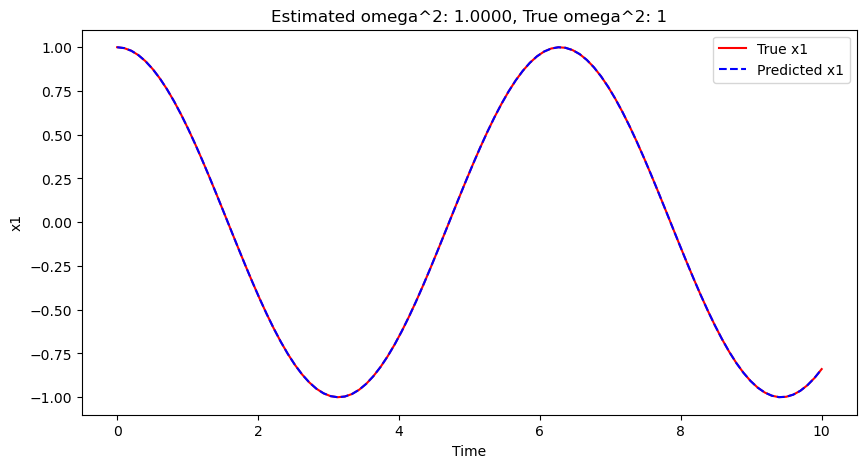

In [13]:
y_pred = odeint(estimated_harmonic_oscillator, y0, t, omega_pred)

plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], 'r-', label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Estimated omega^2: {omega_pred:.4f}, True omega^2: {omega_squared_true}')
plt.show()


In [14]:
n_points = 100
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])

# a more complex function to estimate
omega_squared_true = 4
y = odeint(harmonic_oscillator, y0, t, omega_squared_true)

rng = random.PRNGKey(0)
learning_rate = 1e-3

# initialize
N = 30
state = create_train_state(rng, learning_rate)

trained_state = train_coll(state, t, y, y0, N, num_epochs = 500)

Epoch 0, Loss: 1.5122169951331221
Epoch 50, Loss: 1.4767994028172593
Epoch 100, Loss: 1.476783542312064
Epoch 150, Loss: 1.4767825656897144
Epoch 200, Loss: 1.4767825611312049
Epoch 250, Loss: 1.4767825610992227
Epoch 300, Loss: 1.4767825610985192
Epoch 350, Loss: 1.4767825610989616
Epoch 400, Loss: 1.4767825610991705
Epoch 450, Loss: 1.4767825611027605
